## Experience station data and append additional information

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

# import earthpy.clip as cl  # clipping method causes plt.plot() failure
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt

import unidecode
import fiona

In [2]:
# configure display options
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 20)

pd.options.display.float_format = '{:,.5f}'.format

%matplotlib inline

In [3]:
# read excel file
filename = f'../../dataset/bentre/Toa_do_vitridoman_BenTre.xlsx'
excel = pd.ExcelFile(filename)

filename

'../../dataset/bentre/Toa_do_vitridoman_BenTre.xlsx'

In [4]:
# read a sheet
df = pd.read_excel(excel, sheet_name=0, dtype=str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
STT                                22 non-null object
Tên trạm                           20 non-null object
Tọa độ 
(WGS_1984_UTM_Zone_48N)    21 non-null object
Unnamed: 3                         21 non-null object
dtypes: object(4)
memory usage: 864.0+ bytes


In [5]:
df.head(10)

,STT,Tên trạm,Tọa độ \n(WGS_1984_UTM_Zone_48N),Unnamed: 3
0,NaN,NaN,X,Y
1,1,Tiên Thuỷ,638108.956289,1132743.34179
2,2,Phước Long,654447.978493,1120366.11273
3,3,Mỏ Cày,640695.880964,1114676.77078
4,4,Tân Thiềng,633534.72801,1123276.54032
5,5,Vang Quới Tây,668101.637133,1134363.39362
6,Trạm đo bổ sung,NaN,NaN,NaN
7,6,Cẩm Sơn,647782.351306,1108081.20329
8,7,Lộc Thuận,674962.031074,1132414.50741
9,8,C. Sơn Đốc,661073.138933,1111850.93564


In [6]:
# delete the first column STT
df.drop(columns=['STT'], axis=1, inplace=True)

df.head(10)

,Tên trạm,Tọa độ \n(WGS_1984_UTM_Zone_48N),Unnamed: 3
0,NaN,X,Y
1,Tiên Thuỷ,638108.956289,1132743.34179
2,Phước Long,654447.978493,1120366.11273
3,Mỏ Cày,640695.880964,1114676.77078
4,Tân Thiềng,633534.72801,1123276.54032
5,Vang Quới Tây,668101.637133,1134363.39362
6,NaN,NaN,NaN
7,Cẩm Sơn,647782.351306,1108081.20329
8,Lộc Thuận,674962.031074,1132414.50741
9,C. Sơn Đốc,661073.138933,1111850.93564


In [7]:
# reset column names
df.columns = ['name', 'x', 'y']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 3 columns):
name    20 non-null object
x       21 non-null object
y       21 non-null object
dtypes: object(3)
memory usage: 680.0+ bytes


In [8]:
# drop all rows that have less than 3 columns filled out: missing station name or x or y
df.dropna(thresh=3, inplace=True)

df.head(10)

,name,x,y
1,Tiên Thuỷ,638108.956289,1132743.34179
2,Phước Long,654447.978493,1120366.11273
3,Mỏ Cày,640695.880964,1114676.77078
4,Tân Thiềng,633534.72801,1123276.54032
5,Vang Quới Tây,668101.637133,1134363.39362
7,Cẩm Sơn,647782.351306,1108081.20329
8,Lộc Thuận,674962.031074,1132414.50741
9,C. Sơn Đốc,661073.138933,1111850.93564
10,C. Cái Mít,656680.707953,1117059.977
11,Sơn Phú,651337.942599,1125205.88153


In [9]:
df.tail(10)

,name,x,y
12,Mỹ Thành,645305.990419,1132921.35333
13,Thành Thới A,643380.956561,1110967.48283
14,Hưng Khánh Trung B,637118.658793,1118236.52496
16,Mỹ Hoá,647099.941724,1130345.31149
17,Sơn Đốc,667286.50373,1108588.58448
18,An Thuận,672322.047183,1105548.3639
19,Bến Trại,668547.047183,1092073.3639
20,Hương Mỹ,651972.431176,1104087.86641
21,Bình Đại,685869.535046,1128715.31327
22,Giao Hoà,659097.047183,1137873.3639


In [10]:
# insert 'code' column
df.insert(0, 'code', df['name'].map(lambda name: unidecode.unidecode(name).upper().strip().replace(' ', '')))
        
df.head()

,code,name,x,y
1,TIENTHUY,Tiên Thuỷ,638108.956289,1132743.34179
2,PHUOCLONG,Phước Long,654447.978493,1120366.11273
3,MOCAY,Mỏ Cày,640695.880964,1114676.77078
4,TANTHIENG,Tân Thiềng,633534.72801,1123276.54032
5,VANGQUOITAY,Vang Quới Tây,668101.637133,1134363.39362


In [11]:
# convert x and y to floats
df[['x', 'y']] =df[['x', 'y']].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 1 to 22
Data columns (total 4 columns):
code    20 non-null object
name    20 non-null object
x       20 non-null float64
y       20 non-null float64
dtypes: float64(2), object(2)
memory usage: 800.0+ bytes


In [12]:
df.head()

,code,name,x,y
1,TIENTHUY,Tiên Thuỷ,"638,108.95629","1,132,743.34179"
2,PHUOCLONG,Phước Long,"654,447.97849","1,120,366.11273"
3,MOCAY,Mỏ Cày,"640,695.88096","1,114,676.77078"
4,TANTHIENG,Tân Thiềng,"633,534.72801","1,123,276.54032"
5,VANGQUOITAY,Vang Quới Tây,"668,101.63713","1,134,363.39362"


In [13]:
# convert Pandas dataframe to GeoPandas dataframe with correct projection using 'proj4' related codes
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']), 
                      crs={
                          'proj': 'utm', 
                          'zone': 48, 
                          'ellps': 'WGS84', 
                          'datum': 'WGS84', 
                          'units': 'm', 
                          'no_defs': True})

df.crs

{'proj': 'utm',
 'zone': 48,
 'ellps': 'WGS84',
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True}

In [14]:
df.head()

,code,name,x,y,geometry
1,TIENTHUY,Tiên Thuỷ,"638,108.95629","1,132,743.34179",POINT (638108.956 1132743.342)
2,PHUOCLONG,Phước Long,"654,447.97849","1,120,366.11273",POINT (654447.978 1120366.113)
3,MOCAY,Mỏ Cày,"640,695.88096","1,114,676.77078",POINT (640695.881 1114676.771)
4,TANTHIENG,Tân Thiềng,"633,534.72801","1,123,276.54032",POINT (633534.728 1123276.540)
5,VANGQUOITAY,Vang Quới Tây,"668,101.63713","1,134,363.39362",POINT (668101.637 1134363.394)


In [15]:
# convert station to new projection
df = df.to_crs({'init': 'epsg:4326'})

df.head()

,code,name,x,y,geometry
1,TIENTHUY,Tiên Thuỷ,"638,108.95629","1,132,743.34179",POINT (106.26103 10.24475)
2,PHUOCLONG,Phước Long,"654,447.97849","1,120,366.11273",POINT (106.40969 10.13223)
3,MOCAY,Mỏ Cày,"640,695.88096","1,114,676.77078",POINT (106.28399 10.08130)
4,TANTHIENG,Tân Thiềng,"633,534.72801","1,123,276.54032",POINT (106.21894 10.15931)
5,VANGQUOITAY,Vang Quới Tây,"668,101.63713","1,134,363.39362",POINT (106.53489 10.25822)


In [16]:
# the boundary of all stations
df.total_bounds

array([106.21894412,   9.8758449 , 106.69680699,  10.29033271])

In [17]:
# print station coordinates to manually figure out its height by Google Earch app
[[c, p.y, p.x] for c, p in df[['code', 'geometry']].values]  # station code, longitude, latitude

[['TIENTHUY', 10.244748999979809, 106.26102900000281],
 ['PHUOCLONG', 10.132225016276605, 106.409693992445],
 ['MOCAY', 10.081295038208957, 106.28399303582273],
 ['TANTHIENG', 10.159305612475395, 106.21894411513833],
 ['VANGQUOITAY', 10.258219227426407, 106.53489122963214],
 ['CAMSON', 10.021400018813583, 106.34840497291755],
 ['LOCTHUAN', 10.240297530187904, 106.59742686501805],
 ['C.SONDOC', 10.054969914595649, 106.46980096782256],
 ['C.CAIMIT', 10.102243980753434, 106.4299361479469],
 ['SONPHU', 10.176105968302451, 106.38150128362497],
 ['MYTHANH', 10.246097167386129, 106.3267376371134],
 ['THANHTHOIA', 10.047658874944414, 106.30835762188437],
 ['HUNGKHANHTRUNGB', 10.113608878107502, 106.2514771040363],
 ['MYHOA', 10.222737501096217, 106.34301651957745],
 ['SONDOC', 10.02521742703001, 106.52634634862564],
 ['ANTHUAN', 9.997516000287387, 106.57214728017047],
 ['BENTRAI', 9.87584489783824, 106.53714631788698],
 ['HUONGMY', 9.985135250053444, 106.3864755775526],
 ['BINHDAI', 10.2063509

In [18]:
# manually add 'ft' and 'cm' columns presenting the height from sea level
heights = np.array([7, 13, 22, 17, 31, 19, 9, 2, 12, 24, 23, 0, 8, 0, 1, 0, 0, 6, 5, 10]).astype(float)  # feet

df.insert(4, 'ft', heights)  # feet
df.insert(5, 'cm', heights * 30.48)  # centimeters
        
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 20 entries, 1 to 22
Data columns (total 7 columns):
code        20 non-null object
name        20 non-null object
x           20 non-null float64
y           20 non-null float64
ft          20 non-null float64
cm          20 non-null float64
geometry    20 non-null geometry
dtypes: float64(4), geometry(1), object(2)
memory usage: 1.2+ KB


In [19]:
df.head(10)

,code,name,x,y,ft,cm,geometry
1,TIENTHUY,Tiên Thuỷ,"638,108.95629","1,132,743.34179",7.00000,213.36000,POINT (106.26103 10.24475)
2,PHUOCLONG,Phước Long,"654,447.97849","1,120,366.11273",13.00000,396.24000,POINT (106.40969 10.13223)
3,MOCAY,Mỏ Cày,"640,695.88096","1,114,676.77078",22.00000,670.56000,POINT (106.28399 10.08130)
4,TANTHIENG,Tân Thiềng,"633,534.72801","1,123,276.54032",17.00000,518.16000,POINT (106.21894 10.15931)
5,VANGQUOITAY,Vang Quới Tây,"668,101.63713","1,134,363.39362",31.00000,944.88000,POINT (106.53489 10.25822)
7,CAMSON,Cẩm Sơn,"647,782.35131","1,108,081.20329",19.00000,579.12000,POINT (106.34840 10.02140)
8,LOCTHUAN,Lộc Thuận,"674,962.03107","1,132,414.50741",9.00000,274.32000,POINT (106.59743 10.24030)
9,C.SONDOC,C. Sơn Đốc,"661,073.13893","1,111,850.93564",2.00000,60.96000,POINT (106.46980 10.05497)
10,C.CAIMIT,C. Cái Mít,"656,680.70795","1,117,059.97700",12.00000,365.76000,POINT (106.42994 10.10224)
11,SONPHU,Sơn Phú,"651,337.94260","1,125,205.88153",24.00000,731.52000,POINT (106.38150 10.17611)


In [20]:
df.tail(10)

,code,name,x,y,ft,cm,geometry
12,MYTHANH,Mỹ Thành,"645,305.99042","1,132,921.35333",23.00000,701.04000,POINT (106.32674 10.24610)
13,THANHTHOIA,Thành Thới A,"643,380.95656","1,110,967.48283",0.00000,0.00000,POINT (106.30836 10.04766)
14,HUNGKHANHTRUNGB,Hưng Khánh Trung B,"637,118.65879","1,118,236.52496",8.00000,243.84000,POINT (106.25148 10.11361)
16,MYHOA,Mỹ Hoá,"647,099.94172","1,130,345.31149",0.00000,0.00000,POINT (106.34302 10.22274)
17,SONDOC,Sơn Đốc,"667,286.50373","1,108,588.58448",1.00000,30.48000,POINT (106.52635 10.02522)
18,ANTHUAN,An Thuận,"672,322.04718","1,105,548.36390",0.00000,0.00000,POINT (106.57215 9.99752)
19,BENTRAI,Bến Trại,"668,547.04718","1,092,073.36390",0.00000,0.00000,POINT (106.53715 9.87584)
20,HUONGMY,Hương Mỹ,"651,972.43118","1,104,087.86641",6.00000,182.88000,POINT (106.38648 9.98514)
21,BINHDAI,Bình Đại,"685,869.53505","1,128,715.31327",5.00000,152.40000,POINT (106.69681 10.20635)
22,GIAOHOA,Giao Hoà,"659,097.04718","1,137,873.36390",10.00000,304.80000,POINT (106.45284 10.29033)


In [21]:
# support output format
fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r',
 'TopoJSON': 'r'}

In [22]:
# save to csv file
df.to_file('../../dataset/csv/station.csv', driver='CSV', index = False)

In [23]:
# save to shapefile
df.to_file('../../dataset/station', encoding='utf-8')

## Visualization

In [24]:
# reload stations from shapefile
df = gpd.read_file('../../dataset/station/station.shp', encoding='utf-8')

df.crs

{'init': 'epsg:4326'}

In [25]:
df.head(10)

,code,name,x,y,ft,cm,geometry
0,TIENTHUY,Tiên Thuỷ,"638,108.95629","1,132,743.34179",7.00000,213.36000,POINT (106.26103 10.24475)
1,PHUOCLONG,Phước Long,"654,447.97849","1,120,366.11273",13.00000,396.24000,POINT (106.40969 10.13223)
2,MOCAY,Mỏ Cày,"640,695.88096","1,114,676.77078",22.00000,670.56000,POINT (106.28399 10.08130)
3,TANTHIENG,Tân Thiềng,"633,534.72801","1,123,276.54032",17.00000,518.16000,POINT (106.21894 10.15931)
4,VANGQUOITAY,Vang Quới Tây,"668,101.63713","1,134,363.39362",31.00000,944.88000,POINT (106.53489 10.25822)
5,CAMSON,Cẩm Sơn,"647,782.35131","1,108,081.20329",19.00000,579.12000,POINT (106.34840 10.02140)
6,LOCTHUAN,Lộc Thuận,"674,962.03107","1,132,414.50741",9.00000,274.32000,POINT (106.59743 10.24030)
7,C.SONDOC,C. Sơn Đốc,"661,073.13893","1,111,850.93564",2.00000,60.96000,POINT (106.46980 10.05497)
8,C.CAIMIT,C. Cái Mít,"656,680.70795","1,117,059.97700",12.00000,365.76000,POINT (106.42994 10.10224)
9,SONPHU,Sơn Phú,"651,337.94260","1,125,205.88153",24.00000,731.52000,POINT (106.38150 10.17611)


In [26]:
df.tail(10)

,code,name,x,y,ft,cm,geometry
10,MYTHANH,Mỹ Thành,"645,305.99042","1,132,921.35333",23.00000,701.04000,POINT (106.32674 10.24610)
11,THANHTHOIA,Thành Thới A,"643,380.95656","1,110,967.48283",0.00000,0.00000,POINT (106.30836 10.04766)
12,HUNGKHANHTRUNGB,Hưng Khánh Trung B,"637,118.65879","1,118,236.52496",8.00000,243.84000,POINT (106.25148 10.11361)
13,MYHOA,Mỹ Hoá,"647,099.94172","1,130,345.31149",0.00000,0.00000,POINT (106.34302 10.22274)
14,SONDOC,Sơn Đốc,"667,286.50373","1,108,588.58448",1.00000,30.48000,POINT (106.52635 10.02522)
15,ANTHUAN,An Thuận,"672,322.04718","1,105,548.36390",0.00000,0.00000,POINT (106.57215 9.99752)
16,BENTRAI,Bến Trại,"668,547.04718","1,092,073.36390",0.00000,0.00000,POINT (106.53715 9.87584)
17,HUONGMY,Hương Mỹ,"651,972.43118","1,104,087.86641",6.00000,182.88000,POINT (106.38648 9.98514)
18,BINHDAI,Bình Đại,"685,869.53505","1,128,715.31327",5.00000,152.40000,POINT (106.69681 10.20635)
19,GIAOHOA,Giao Hoà,"659,097.04718","1,137,873.36390",10.00000,304.80000,POINT (106.45284 10.29033)


In [27]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
code        20 non-null object
name        20 non-null object
x           20 non-null float64
y           20 non-null float64
ft          20 non-null float64
cm          20 non-null float64
geometry    20 non-null geometry
dtypes: float64(4), geometry(1), object(2)
memory usage: 1.2+ KB


In [28]:
# load Vietnam boundary
vn = gpd.read_file('../../map/VietnamBound4795/VietnamBound47.shp', encoding='utf-8')

vn.crs

{'init': 'epsg:4326'}

In [29]:
vn.head()

,id,country,name,enname,locname,...,timestamp,note,rpath,ISO3166_2,geometry
0,49915,VNM,Vietnam,Vietnam,Vi?t Nam,...,2018-10-27 07:56:03,the boundary of Vietnam is partly based on str...,"49915,0",None,"MULTIPOLYGON (((112.92067 7.89222, 112.92068 7..."


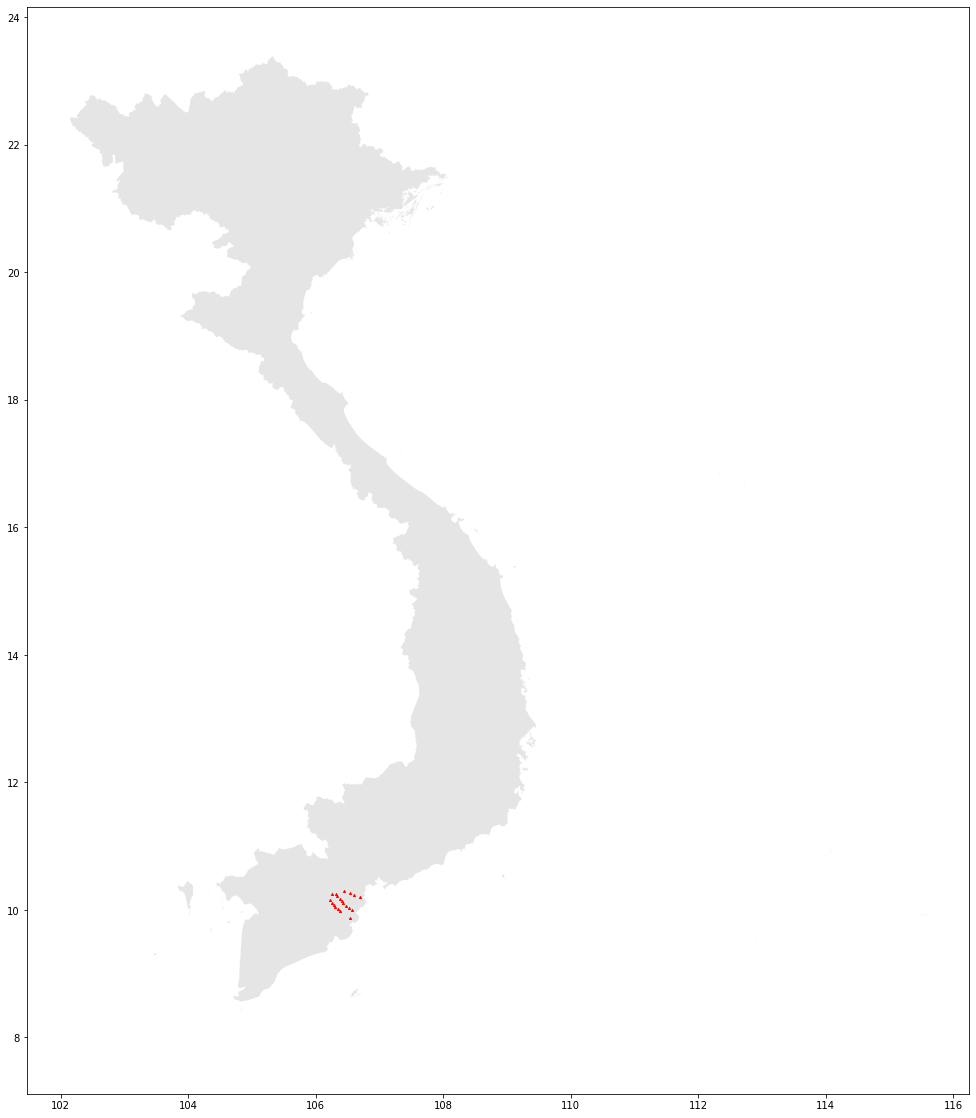

In [30]:
# visualize stations on the entire of Vietnam
fig, ax = plt.subplots(figsize=(20, 20))

vn.plot(ax=ax, alpha=0.2, color='grey')
df.plot(ax=ax, markersize=4, color='red', marker='^')

In [31]:
# create bentre dataframe for the boundary of stations
xmin, ymin, xmax, ymax = df.total_bounds

# add margins
margin = 0.3

xmin -= margin
xmax += margin
ymin -= margin
ymax += margin

p1 = Point(xmin, ymin)
p2 = Point(xmin, ymax)
p3 = Point(xmax, ymax)
p4 = Point(xmax, ymin)

np1 = (p1.coords.xy[0][0], p1.coords.xy[1][0])
np2 = (p2.coords.xy[0][0], p2.coords.xy[1][0])
np3 = (p3.coords.xy[0][0], p3.coords.xy[1][0])
np4 = (p4.coords.xy[0][0], p4.coords.xy[1][0])

bentre = gpd.GeoDataFrame(gpd.GeoSeries(Polygon([np1, np2, np3, np4])), columns=['geometry'])

bentre.head()

,geometry
0,"POLYGON ((105.91894 9.57584, 105.91894 10.5903..."


In [32]:
# join vn and df for bentre
bentre = gpd.overlay(bentre, vn, how='intersection')

bentre.head()

,id,country,name,enname,locname,...,timestamp,note,rpath,ISO3166_2,geometry
0,49915,VNM,Vietnam,Vietnam,Vi?t Nam,...,2018-10-27 07:56:03,the boundary of Vietnam is partly based on str...,"49915,0",None,"MULTIPOLYGON (((105.91894 9.57584, 105.91894 1..."


In [33]:
# load Vietnam waterways
waterways = gpd.read_file('../../map/vietnam-latest-free/gis_osm_waterways_free_1/gis_osm_waterways_free_1.shp', encoding='utf-8')

waterways.crs

{'init': 'epsg:4326'}

In [34]:
waterways.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18614 entries, 0 to 18613
Data columns (total 6 columns):
osm_id      18614 non-null object
code        18614 non-null int64
fclass      18614 non-null object
width       18614 non-null int64
name        2375 non-null object
geometry    18614 non-null geometry
dtypes: geometry(1), int64(2), object(3)
memory usage: 872.7+ KB


In [35]:
waterways.head()

,osm_id,code,fclass,width,name,geometry
0,10233661,8101,river,0,None,"LINESTRING (105.85852 20.95724, 105.85835 20.9..."
1,10233838,8103,canal,0,Sông Sét,"LINESTRING (105.84082 20.99153, 105.84064 20.9..."
2,10237319,8101,river,0,None,"LINESTRING (105.85777 20.95803, 105.85835 20.9..."
3,10237514,8101,river,0,None,"LINESTRING (105.81316 20.96041, 105.81315 20.9..."
4,10238737,8101,river,0,None,"LINESTRING (105.85885 20.96517, 105.86049 20.9..."


In [36]:
# types of waterways
waterways['fclass'].value_counts()

stream    6598
river     5853
canal     5605
drain      558
Name: fclass, dtype: int64

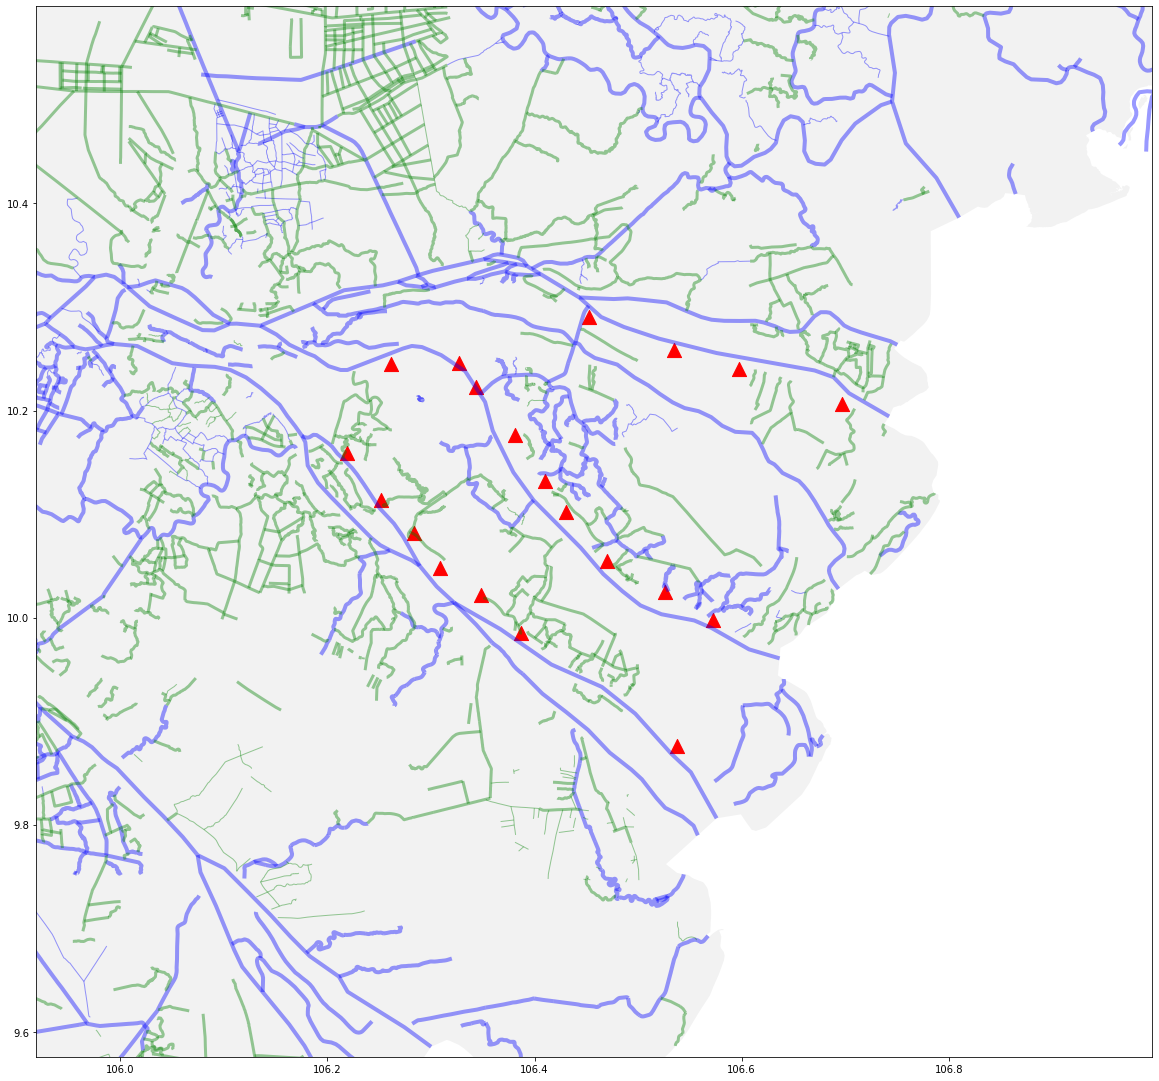

In [42]:
# visualize stations
fig, ax = plt.subplots(figsize=(20, 20))
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax])

vn.plot(ax=ax, alpha=0.1, color='grey')

# natural
waterways[waterways['fclass'] == 'river'].plot(ax=ax, alpha=0.4, color='blue', lw=4)
waterways[waterways['fclass'] == 'stream'].plot(ax=ax, alpha=0.4, color='blue', lw=1)

# man made
waterways[waterways['fclass'] == 'canal'].plot(ax=ax, alpha=0.4, color='green', lw=3)
waterways[waterways['fclass'] == 'drain'].plot(ax=ax, alpha=0.4, color='green', lw=1)

df.plot(ax=ax, markersize=200, color='red', marker='^')

In [38]:
# clip waterway into bentre
# does not work
# waterways = cl.clip_shp(waterways, bentre)
# waterways.info()
# waterways.head()